In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

c:\Users\Nam Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
data = pd.read_csv("gold_price_1.csv")
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values("Date")
df = data.copy()

In [4]:
start, end = df['Date'].min(), df['Date'].max()
full_days = pd.date_range(start=start, end=end, freq='D')
missing_days_count = len(full_days) - df['Date'].nunique()
print(f"Date range: {start.date()} -> {end.date()}")
print(f"Total calendar days in range: {len(full_days)}")
print(f"Recorded days in dataset: {df['Date'].nunique()}")
print(f"Missing calendar days: {missing_days_count}")

Date range: 2008-01-02 -> 2025-08-29
Total calendar days in range: 6450
Recorded days in dataset: 4517
Missing calendar days: 1933


In [5]:
df_indexed = df.set_index('Date').reindex(full_days)   
df_indexed.index.name = 'Date'
cols = df_indexed.columns.tolist()

In [6]:
def fill_by_neighbor_mean(s: pd.Series) -> pd.Series:
    s = s.copy()
    if s.dtype == object:
        try:
            s = s.astype(float)
        except Exception:
            return s

    s_ffill = s.ffill()
    s_bfill = s.bfill()
    mask_missing = s.isna()

    both = mask_missing & s_ffill.notna() & s_bfill.notna()
    only_ffill = mask_missing & s_ffill.notna() & s_bfill.isna()
    only_bfill = mask_missing & s_bfill.notna() & s_ffill.isna()

    s_out = s.copy()
    s_out.loc[both] = (s_ffill.loc[both] + s_bfill.loc[both]) / 2.0
    s_out.loc[only_ffill] = s_ffill.loc[only_ffill]
    s_out.loc[only_bfill] = s_bfill.loc[only_bfill]

    return s_out

In [7]:
numeric_cols = df_indexed.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns to fill:", numeric_cols)

df_filled = df_indexed.copy()


Numeric columns to fill: ['Gold', 'USD_Index', 'Oil', 'Silver', 'SP500', 'Bitcoin', 'Interest_Rate', '10Y_Treasury_Yield', 'Inflation_CPI', 'Unemployment', 'WarIndicator']


In [8]:
for c in numeric_cols:
    df_filled[c] = fill_by_neighbor_mean(df_filled[c])

binary_cols = [c for c in ['WarIndicator'] if c in df_filled.columns]
for c in binary_cols:
    df_filled[c] = df_filled[c].round().astype('Int64') 

missing_after = df_filled.isna().sum()
print("\nMissing values after neighbor-mean fill (per column):")
print(missing_after[missing_after > 0].sort_values(ascending=False))

df_filled = df_filled.reset_index().rename(columns={'index': 'Date'})

print("\nSample head (after filling):")
print(df_filled.head(8))
print("\nSample tail (after filling):")
print(df_filled.tail(8))


Missing values after neighbor-mean fill (per column):
Series([], dtype: int64)

Sample head (after filling):
        Date    Gold  USD_Index    Oil  Silver     SP500  Bitcoin  \
0 2008-01-02  857.00      76.01  99.62  15.170  1447.160   457.33   
1 2008-01-03  866.40      75.92  99.18  15.380  1447.160   457.33   
2 2008-01-04  863.10      75.82  97.91  15.350  1411.630   457.33   
3 2008-01-05  861.35      76.01  96.50  15.265  1413.905   457.33   
4 2008-01-06  861.35      76.01  96.50  15.265  1413.905   457.33   
5 2008-01-07  859.60      76.20  95.09  15.180  1416.180   457.33   
6 2008-01-08  878.00      76.12  96.33  15.710  1390.190   457.33   
7 2008-01-09  879.50      76.46  95.67  15.730  1409.130   457.33   

   Interest_Rate  10Y_Treasury_Yield  Inflation_CPI  Unemployment  \
0           3.94                4.36         212.17           5.0   
1           3.94                4.36         212.17           5.0   
2           3.94                4.36         212.17          

In [9]:
df_filled.shape

(6450, 12)

In [10]:

df = df_filled.rename(columns={'Date': 'ds', 'Gold': 'y'})

In [11]:
regressors = [
    "USD_Index", "Oil", "Silver", "SP500", "Bitcoin",
    "Interest_Rate", "10Y_Treasury_Yield", "Inflation_CPI", "Unemployment"
]

In [12]:
df["Bitcoin"] = df["Bitcoin"].fillna(0)
df[regressors] = df[regressors].fillna(method="ffill")
df.head(15)

C:\Users\Nam Nguyen\AppData\Local\Temp\ipykernel_5352\1058167271.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[regressors] = df[regressors].fillna(method="ffill")


,ds,y,USD_Index,Oil,Silver,SP500,Bitcoin,Interest_Rate,10Y_Treasury_Yield,Inflation_CPI,Unemployment,WarIndicator
0,2008-01-02,857.00,76.01,99.620,15.170,1447.160,457.33,3.94,4.36,212.17,5.0,0
1,2008-01-03,866.40,75.92,99.180,15.380,1447.160,457.33,3.94,4.36,212.17,5.0,0
2,2008-01-04,863.10,75.82,97.910,15.350,1411.630,457.33,3.94,4.36,212.17,5.0,0
3,2008-01-05,861.35,76.01,96.500,15.265,1413.905,457.33,3.94,4.36,212.17,5.0,0
4,2008-01-06,861.35,76.01,96.500,15.265,1413.905,457.33,3.94,4.36,212.17,5.0,0
5,2008-01-07,859.60,76.20,95.090,15.180,1416.180,457.33,3.94,4.36,212.17,5.0,0
6,2008-01-08,878.00,76.12,96.330,15.710,1390.190,457.33,3.94,4.36,212.17,5.0,0
7,2008-01-09,879.50,76.46,95.670,15.730,1409.130,457.33,3.94,4.36,212.17,5.0,0
8,2008-01-10,891.70,76.00,93.710,16.170,1420.330,457.33,3.94,4.36,212.17,5.0,0
9,2008-01-11,896.10,76.04,92.690,16.270,1401.020,457.33,3.94,4.36,212.17,5.0,0


In [13]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=False)
for reg in regressors:
    m.add_regressor(reg)

m.fit(df[['ds', 'y'] + regressors])

21:54:20 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
future = df[['ds'] + regressors]
forecast = m.predict(future)
df['prophet_base'] = forecast['yhat']

In [15]:
df.head(5)

,ds,y,USD_Index,Oil,Silver,SP500,Bitcoin,Interest_Rate,10Y_Treasury_Yield,Inflation_CPI,Unemployment,WarIndicator,prophet_base
0,2008-01-02,857.00,76.01,99.62,15.170,1447.160,457.33,3.94,4.36,212.17,5.0,0,714.417073
1,2008-01-03,866.40,75.92,99.18,15.380,1447.160,457.33,3.94,4.36,212.17,5.0,0,722.679186
2,2008-01-04,863.10,75.82,97.91,15.350,1411.630,457.33,3.94,4.36,212.17,5.0,0,732.318398
3,2008-01-05,861.35,76.01,96.50,15.265,1413.905,457.33,3.94,4.36,212.17,5.0,0,732.729208
4,2008-01-06,861.35,76.01,96.50,15.265,1413.905,457.33,3.94,4.36,212.17,5.0,0,733.390081


In [16]:
df['residual'] = df['y'] - df['prophet_base']

In [17]:
max_lag = 26
for lag in range(1, max_lag + 1):
    df[f'residual_lag_{lag}'] = df['residual'].shift(lag)

In [18]:
df['resid_mean_4'] = df['residual'].shift(1).rolling(4).mean()
df['resid_std_4'] = df['residual'].shift(1).rolling(4).std()

In [19]:
df['Gold_USD_ratio'] = df['y'] / df['USD_Index']
df['Gold_Oil_ratio'] = df['y'] / df['Oil']
df['Gold_Sliver_ratio'] = df['y'] /df['Silver']

In [20]:
df = df.dropna()

In [21]:
df

,ds,y,USD_Index,Oil,Silver,SP500,Bitcoin,Interest_Rate,10Y_Treasury_Yield,Inflation_CPI,...,residual_lag_22,residual_lag_23,residual_lag_24,residual_lag_25,residual_lag_26,resid_mean_4,resid_std_4,Gold_USD_ratio,Gold_Oil_ratio,Gold_Sliver_ratio
26,2008-01-28,927.1,75.70,90.99,16.69,1353.96,457.33,3.94,4.36,212.17,...,127.959919,128.620792,130.781602,143.720814,142.582927,130.656181,6.249867,12.247028,10.189032,55.548232
27,2008-01-29,925.1,75.67,91.64,16.75,1362.30,457.33,3.94,4.36,212.17,...,125.870870,127.959919,128.620792,130.781602,143.720814,135.697722,6.083664,12.225453,10.094937,55.229851
28,2008-01-30,920.6,75.14,92.33,16.71,1355.81,457.33,3.94,4.36,212.17,...,129.038703,125.870870,127.959919,128.620792,130.781602,139.596565,4.560383,12.251797,9.970757,55.092759
29,2008-01-31,922.7,75.29,91.75,16.95,1378.55,457.33,3.94,4.36,212.17,...,133.616847,129.038703,125.870870,127.959919,128.620792,140.351476,3.692261,12.255280,10.056676,54.436578
30,2008-02-01,908.7,75.57,88.96,16.82,1395.42,457.33,2.98,3.62,212.69,...,125.573641,133.616847,129.038703,125.870870,127.959919,140.792279,3.141435,12.024613,10.214703,54.024970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6445,2025-08-25,3373.8,98.32,64.80,38.68,6439.32,110124.35,4.33,4.23,322.13,...,52.666662,53.838056,44.331190,22.823434,1.618998,-5.346746,10.346141,34.314483,52.064815,87.223371
6446,2025-08-26,3388.6,98.12,63.25,38.58,6465.94,111802.66,4.33,4.23,322.13,...,62.061197,52.666662,53.838056,44.331190,22.823434,2.598747,8.095334,34.535263,53.574704,87.833074
6447,2025-08-27,3404.6,98.13,64.15,38.69,6481.40,111222.06,4.33,4.23,322.13,...,48.583662,62.061197,52.666662,53.838056,44.331190,10.672794,10.677109,34.694793,53.072486,87.996898
6448,2025-08-28,3431.8,97.74,64.60,39.19,6501.86,112544.80,4.33,4.23,322.13,...,40.775873,48.583662,62.061197,52.666662,53.838056,20.814442,17.722820,35.111520,53.123839,87.568257


In [22]:
train_size = int(len(df)*0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train = train.drop(columns=['ds', 'y', 'residual'])
y_train = train['residual']
X_test = test.drop(columns=['ds', 'y', 'residual'])
y_test = test['residual']

# XG BOOST

In [23]:
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [400, 800],
    'max_depth': [3, 5],
    'learning_rate': [0.03, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0.1, 1.0],  
    'reg_lambda': [1.0, 2.0]  
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror') 
grid = GridSearchCV(
    xgb, param_grid, cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1, n_jobs=-1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda': 2.0, 'subsample': 1.0}


In [24]:
test = test.copy()
test.loc[:, 'resid_pred'] = best_model.predict(X_test)
test.loc[:, 'final_pred'] = test['prophet_base'] + test['resid_pred']

In [25]:
rmse = np.sqrt(mean_squared_error(test['y'], test['final_pred']))
mae = mean_absolute_error(test['y'], test['final_pred'])
mape = np.mean(np.abs((test['y'] - test['final_pred']) / test['y'])) * 100

print(f"\nFinal Test RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")


Final Test RMSE: 19.20, MAE: 13.42, MAPE: 0.58%


In [26]:
compare = test[['ds', 'y', 'prophet_base', 'resid_pred', 'final_pred']].copy()
compare = compare.rename(columns={'y': 'actual'})
print(compare.tail(10))


             ds  actual  prophet_base  resid_pred   final_pred
6440 2025-08-20  3343.4   3350.352749  -18.522936  3331.829813
6441 2025-08-21  3336.9   3356.124029   -6.026669  3350.097361
6442 2025-08-22  3374.4   3381.661306  -13.672002  3367.989305
6443 2025-08-23  3374.1   3371.240817   -9.973266  3361.267551
6444 2025-08-24  3374.1   3371.860831    1.310309  3373.171140
6445 2025-08-25  3373.8   3361.242059   -4.413065  3356.828994
6446 2025-08-26  3388.6   3363.565115    0.502167  3364.067283
6447 2025-08-27  3404.6   3361.174225   14.217202  3375.391427
6448 2025-08-28  3431.8   3375.422645   32.219135  3407.641780
6449 2025-08-29  3473.7   3405.245901   46.099945  3451.345846


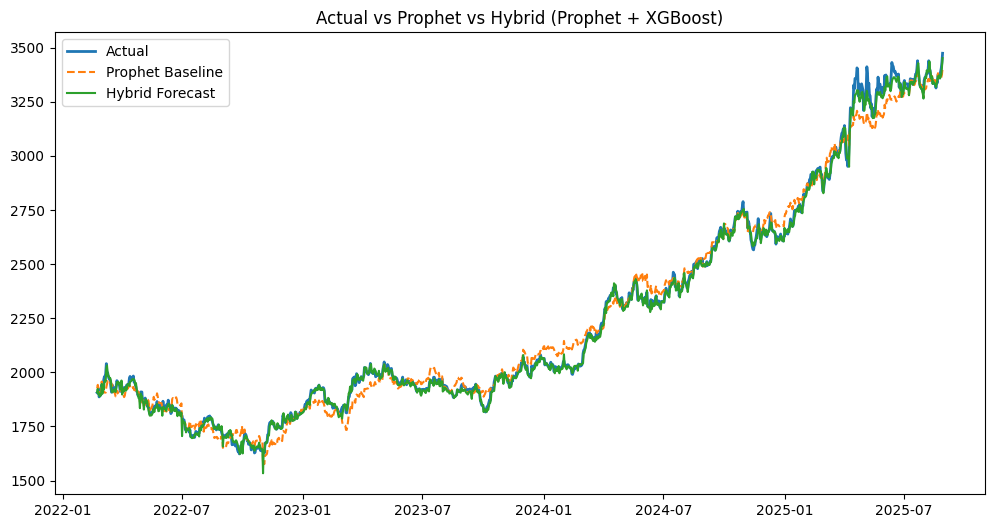

In [27]:
plt.figure(figsize=(12,6))
plt.plot(compare['ds'], compare['actual'], label='Actual', linewidth=2)
plt.plot(compare['ds'], compare['prophet_base'], label='Prophet Baseline', linestyle='--')
plt.plot(compare['ds'], compare['final_pred'], label='Hybrid Forecast', linestyle='-')
plt.legend()
plt.title("Actual vs Prophet vs Hybrid (Prophet + XGBoost)")
plt.show()

In [28]:
y_true_cls = (test['y'].diff().fillna(0) > 0).astype(int)
y_pred_cls = (test['final_pred'].diff().fillna(0) > 0).astype(int)

print("\nAccuracy:", accuracy_score(y_true_cls, y_pred_cls))
print("Confusion matrix:\n", confusion_matrix(y_true_cls, y_pred_cls))


Accuracy: 0.6287937743190661
Confusion matrix:
 [[418 295]
 [182 390]]


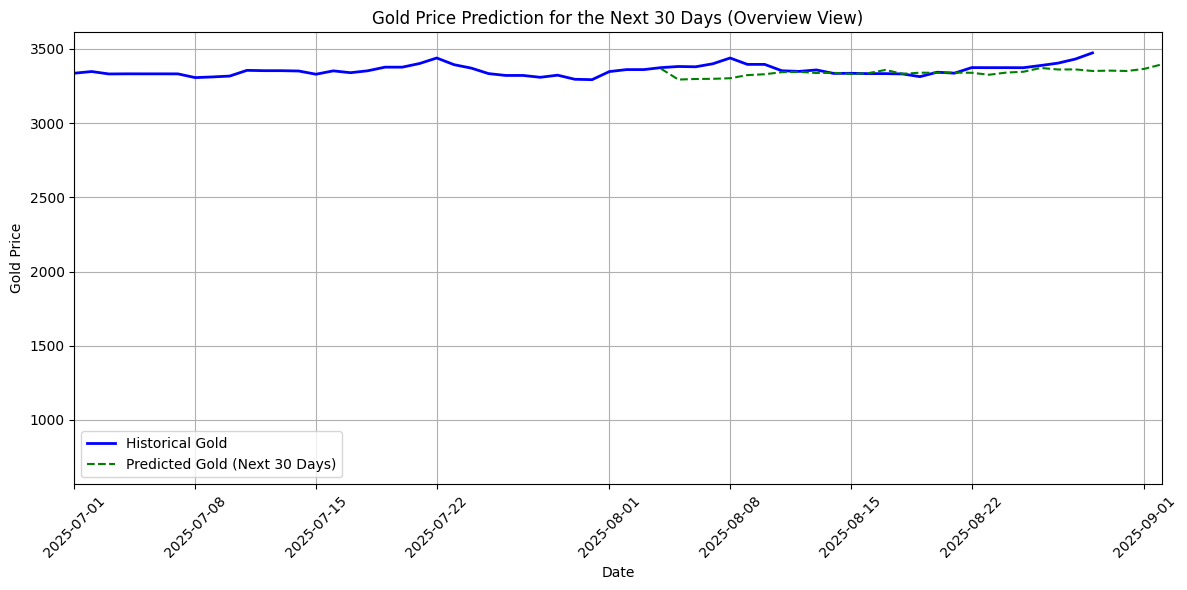

            Predicted_Gold  Predicted_Trend
Date                                       
2025-08-04     3366.480478                1
2025-08-05     3293.849666                0
2025-08-06     3297.692800                0
2025-08-07     3298.864194                0
2025-08-08     3302.819659                0
2025-08-09     3323.797194                0
2025-08-10     3329.704983                0
2025-08-11     3343.736630                0
2025-08-12     3345.962788                0
2025-08-13     3338.047476                0
2025-08-14     3339.486317                0
2025-08-15     3331.591691                0
2025-08-16     3336.929270                0
2025-08-17     3358.676457                0
2025-08-18     3332.561369                0
2025-08-19     3340.242093                0
2025-08-20     3339.336866                0
2025-08-21     3340.579672                0
2025-08-22     3339.543157                0
2025-08-23     3326.340142                0
2025-08-24     3340.833605      

In [29]:
def predict_next_30_days(df, model_prophet, model_xgb, regressors, lookback=60, horizon=30):
    future = df[['ds'] + regressors]
    forecast_prophet = model_prophet.predict(future)
    df['prophet_base'] = forecast_prophet['yhat'] 

    df['residual'] = df['y'] - df['prophet_base']

    max_lag = 26 
    for lag in range(1, max_lag + 1):
        df[f'residual_lag_{lag}'] = df['residual'].shift(lag)

    df['resid_mean_4'] = df['residual'].shift(1).rolling(4).mean()
    df['resid_std_4'] = df['residual'].shift(1).rolling(4).std()

    df = df.dropna()
    X = df.drop(columns=['ds', 'y', 'residual'])
    y = df['residual']

    last_seq = X.iloc[-lookback:].copy() 
    residual_preds = []

    for _ in range(horizon):
        residual_pred = model_xgb.predict(last_seq)
        residual_preds.append(residual_pred[0])

        new_row = last_seq.iloc[-1].copy()  
        new_row['residual'] = residual_pred[0]  
        last_seq = pd.DataFrame([new_row], columns=last_seq.columns)

    residual_preds_rescaled = np.array(residual_preds)  
    future_dates = pd.date_range(df['ds'].iloc[-1] + pd.Timedelta(days=1), periods=horizon, freq="D")

    predicted_gold = forecast_prophet['yhat'].iloc[-horizon:].values + residual_preds_rescaled

    forecast_df = pd.DataFrame({
        "Date": future_dates,
        "Predicted_Gold": predicted_gold,
        "Predicted_Trend": np.where(residual_preds_rescaled > 0, 1, 0)  
    }).set_index("Date")

    return forecast_df

forecast_next_30_days = predict_next_30_days(df, m, best_model, regressors)

plt.figure(figsize=(12, 6))

plt.plot(df['ds'], df['y'], label="Historical Gold", color="blue", linewidth=2)

plt.plot(forecast_next_30_days.index, forecast_next_30_days['Predicted_Gold'], label="Predicted Gold (Next 30 Days)", linestyle="--", color="green")

plt.xlim(df['ds'].iloc[-60], forecast_next_30_days.index[-1])

plt.legend()
plt.title("Gold Price Prediction for the Next 30 Days (Overview View)")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout() 

plt.show()

print(forecast_next_30_days)


In [30]:
print(forecast_df)

NameError: name 'forecast_df' is not defined

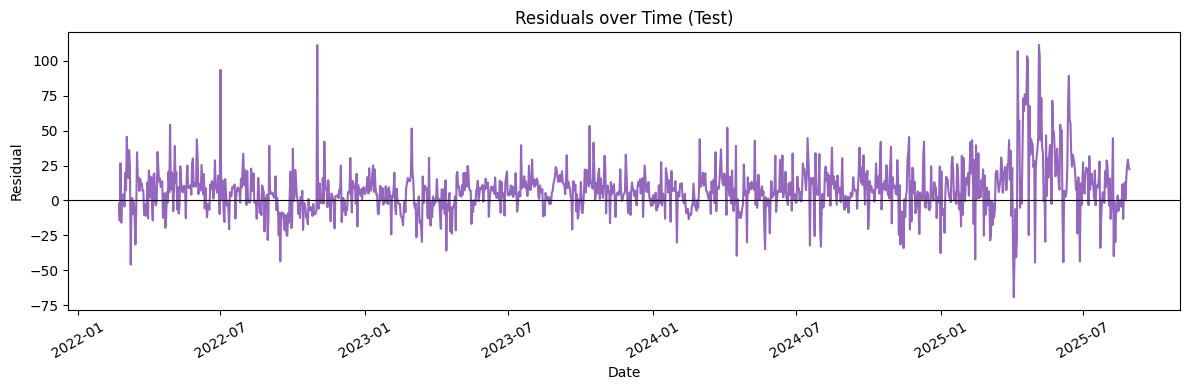

In [ ]:
test = test.copy()
test['error'] = test['y'] - test['final_pred']

plt.figure(figsize=(12,4))
plt.plot(test['ds'], test['error'], label='Residual (y - hybrid_pred)', color='tab:purple')
plt.axhline(0, color='k', linewidth=0.8)
plt.title('Residuals over Time (Test)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


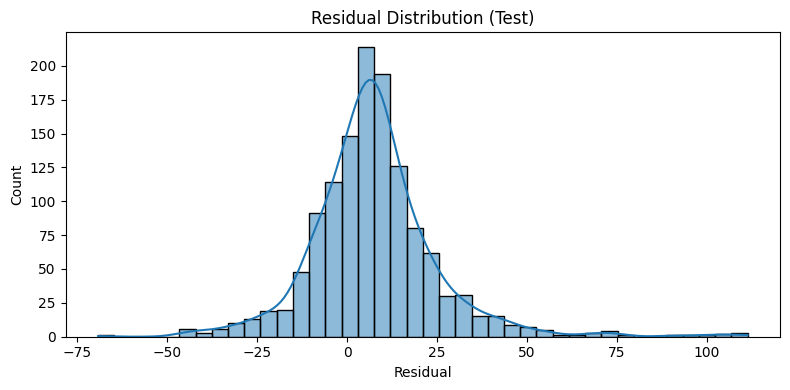

Residual mean: 7.446579090541026
Residual std : 17.702795294986156
Residual skew: 1.1539377307903722
Residual kurt: 5.991682437854196


In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.histplot(test['error'].dropna(), kde=True, bins=40)
plt.title('Residual Distribution (Test)')
plt.xlabel('Residual')
plt.tight_layout()
plt.show()

# summary stats
print("Residual mean:", test['error'].mean())
print("Residual std :", test['error'].std())
print("Residual skew:", test['error'].skew())
print("Residual kurt:", test['error'].kurtosis())


C:\Users\MTHH\AppData\Local\Temp\ipykernel_15172\3001631485.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


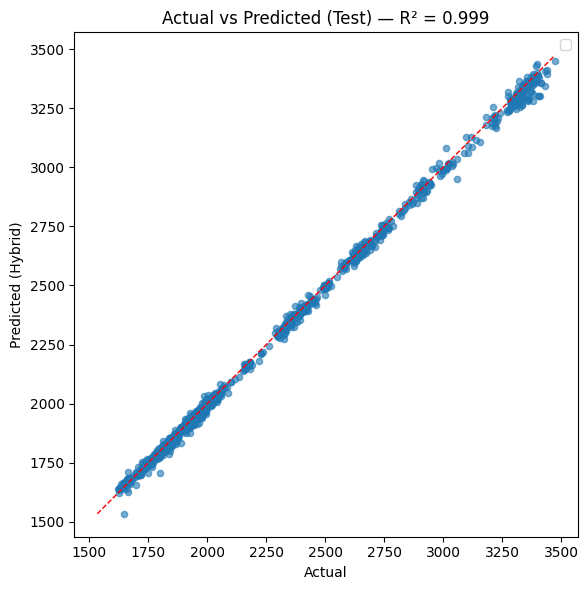

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(test['y'], test['final_pred'])

plt.figure(figsize=(6,6))
plt.scatter(test['y'], test['final_pred'], alpha=0.6, s=20)
mn = min(test['y'].min(), test['final_pred'].min())
mx = max(test['y'].max(), test['final_pred'].max())
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
plt.title(f'Actual vs Predicted (Test) — R² = {r2:.3f}')
plt.xlabel('Actual')
plt.ylabel('Predicted (Hybrid)')
plt.legend()
plt.tight_layout()
plt.show()


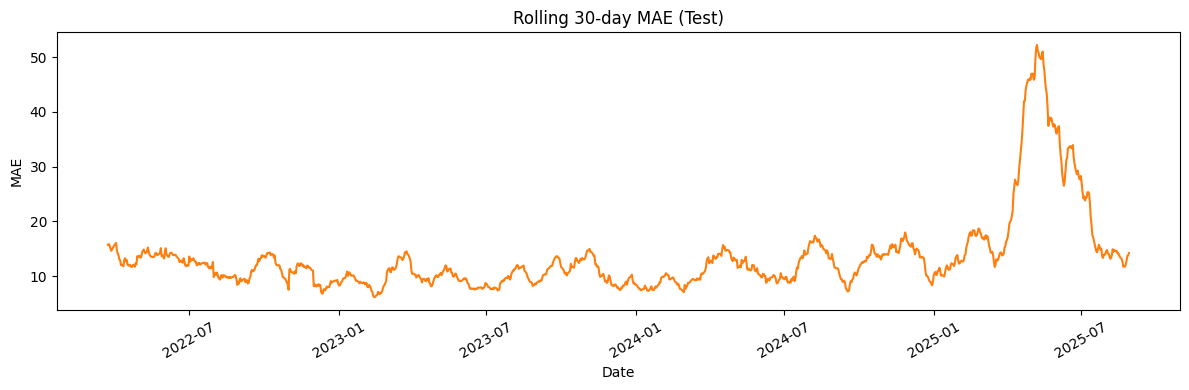

In [ ]:
test['abs_err'] = test['error'].abs()
test['MAE_30d'] = test['abs_err'].rolling(window=30).mean()

plt.figure(figsize=(12,4))
plt.plot(test['ds'], test['MAE_30d'], label='30-day rolling MAE', color='tab:orange')
plt.title('Rolling 30-day MAE (Test)')
plt.xlabel('Date')
plt.ylabel('MAE')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


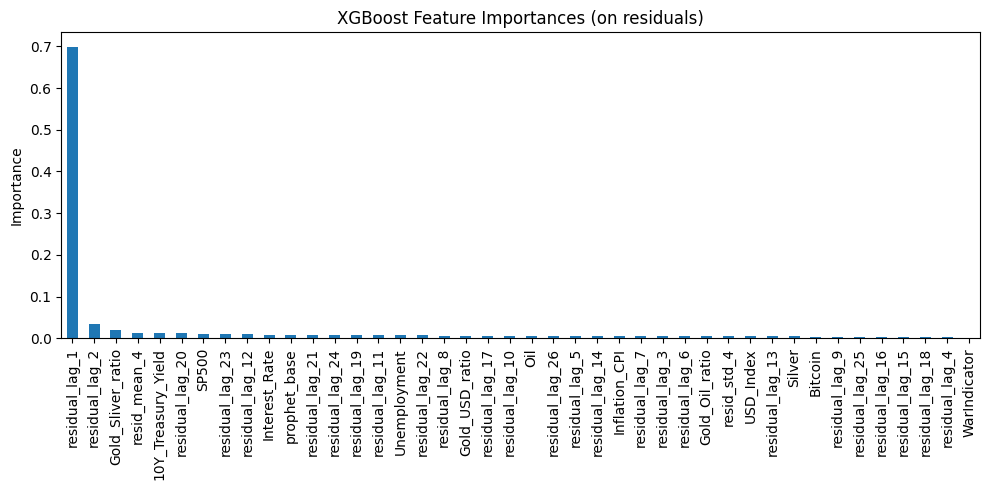

residual_lag_1        0.698566
residual_lag_2        0.034968
Gold_Sliver_ratio     0.019524
resid_mean_4          0.013284
10Y_Treasury_Yield    0.013070
residual_lag_20       0.012990
SP500                 0.011414
residual_lag_23       0.009643
residual_lag_12       0.009133
Interest_Rate         0.008770
prophet_base          0.008463
residual_lag_21       0.007974
residual_lag_24       0.007551
residual_lag_19       0.007146
residual_lag_11       0.007093
dtype: float32


In [ ]:
feat_imp = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,5))
feat_imp.plot(kind='bar')
plt.title('XGBoost Feature Importances (on residuals)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# print table
print(feat_imp.head(15))


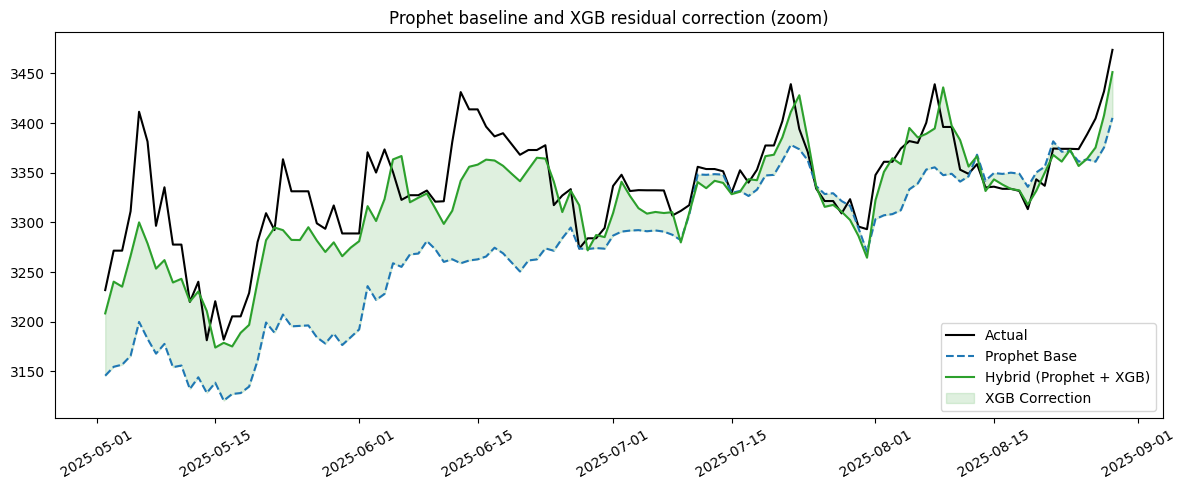

In [ ]:
# pick a period (last N days on test) to visualize clearly
N = 120
sub = compare.tail(N).copy()

plt.figure(figsize=(12,5))
plt.plot(sub['ds'], sub['actual'], label='Actual', color='black', linewidth=1.5)
plt.plot(sub['ds'], sub['prophet_base'], label='Prophet Base', color='tab:blue', linestyle='--')
plt.plot(sub['ds'], sub['prophet_base'] + sub['resid_pred'], label='Hybrid (Prophet + XGB)', color='tab:green')
plt.fill_between(sub['ds'], sub['prophet_base'], sub['prophet_base'] + sub['resid_pred'],
                 color='tab:green', alpha=0.15, label='XGB Correction')
plt.legend()
plt.title('Prophet baseline and XGB residual correction (zoom)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


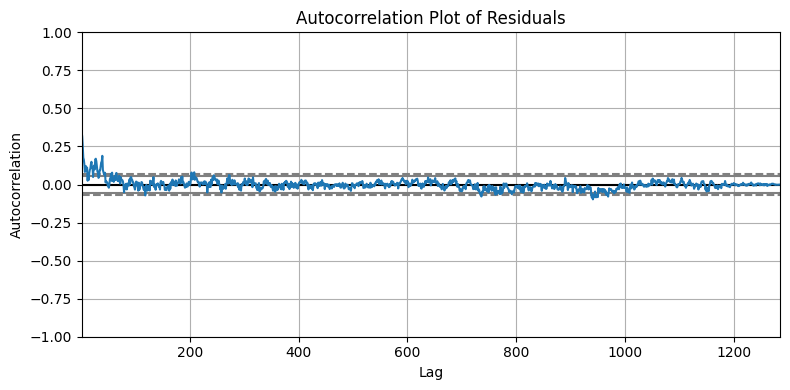

In [ ]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(8,4))
autocorrelation_plot(test['error'].dropna())
plt.title('Autocorrelation Plot of Residuals')
plt.tight_layout()
plt.show()


                                                                                                                     params  \
67  {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda'...   
3   {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda'...   
71  {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 400, 'reg_alpha': 1.0, 'reg_lambda'...   
39  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400, 'reg_alpha': 1.0, 'reg_lambda'...   
1   {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda'...   
7   {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 400, 'reg_alpha': 1.0, 'reg_lambda'...   
35  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400, 'reg_alpha': 0.1, 're

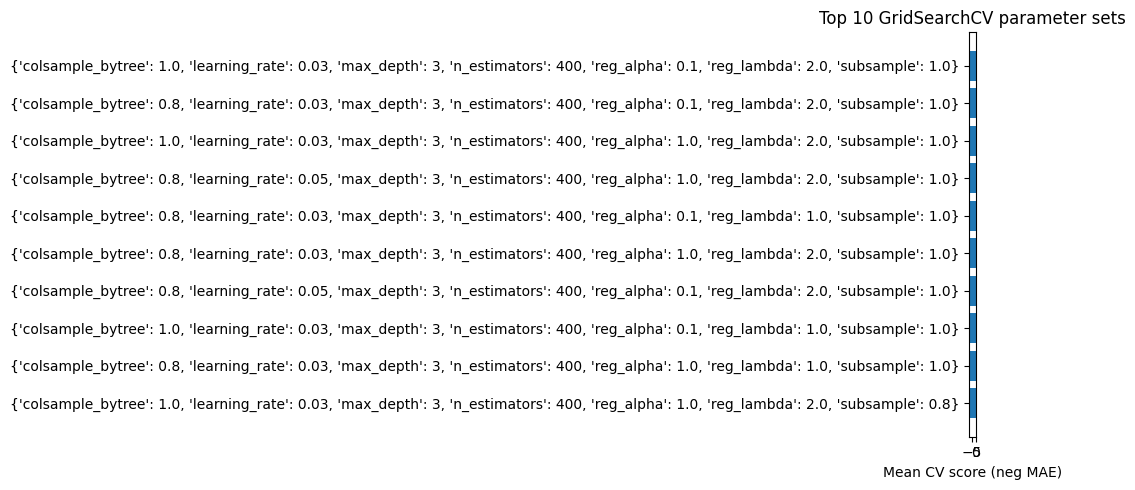

In [ ]:
cv_df = pd.DataFrame(grid.cv_results_)
# show top 10 by mean_test_score (higher is better because you used neg MAE)
cv_df = cv_df.sort_values('mean_test_score', ascending=False)
pd.set_option('display.max_colwidth', 120)
print(cv_df[['params','mean_test_score','std_test_score']].head(10))

# Optional bar chart of top 10 mean scores
top10 = cv_df.head(10).copy()
plt.figure(figsize=(10,5))
plt.barh(range(len(top10)), top10['mean_test_score'].values[::-1])
plt.yticks(range(len(top10)), top10['params'].astype(str).values[::-1])
plt.xlabel('Mean CV score (neg MAE)')
plt.title('Top 10 GridSearchCV parameter sets')
plt.tight_layout()
plt.show()


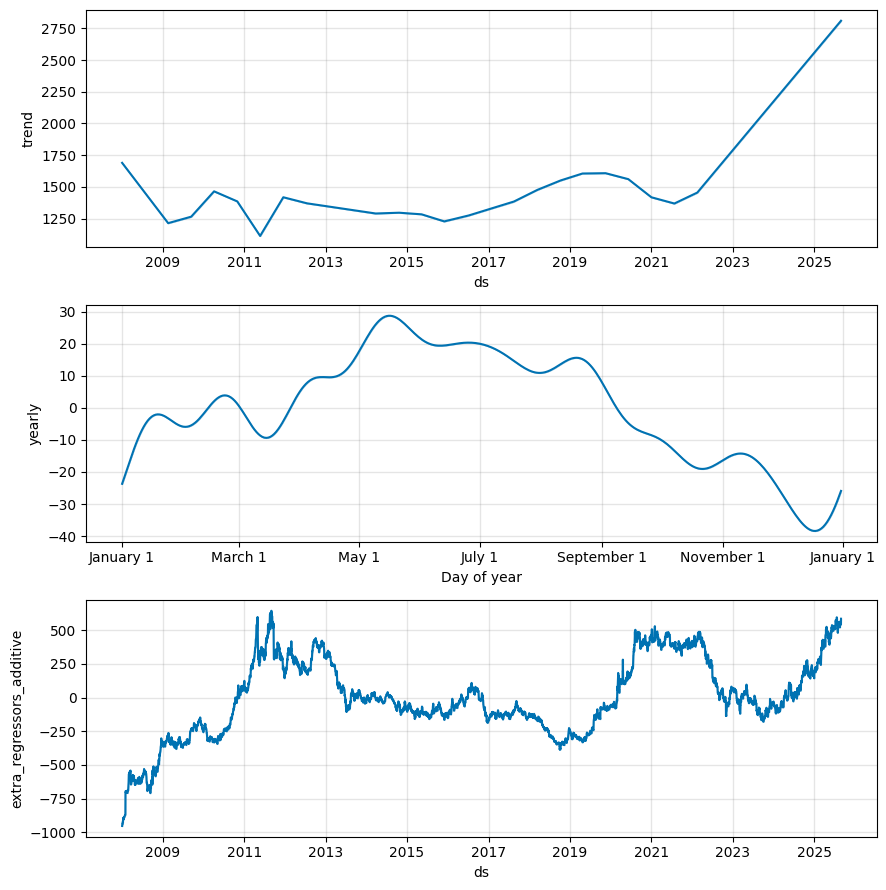

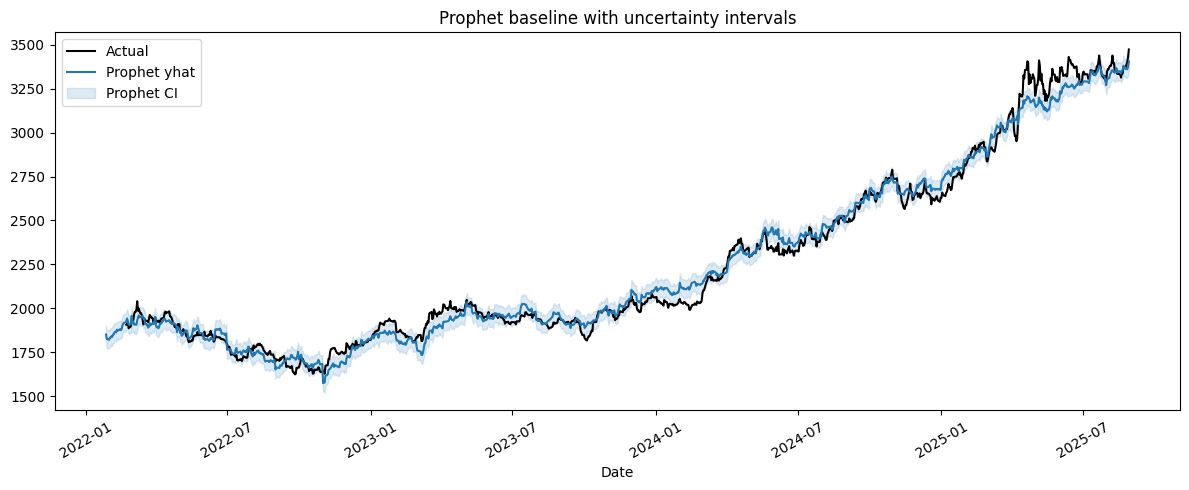

In [ ]:
# Prophet components (trend, yearly seasonality, regressors)
fig = m.plot_components(forecast)
plt.show()

# Prophet baseline with Prophet's uncertainty bands (yhat_lower/yhat_upper)
plt.figure(figsize=(12,5))
plt.plot(df['ds'].iloc[train_size:], df['y'].iloc[train_size:], label='Actual', color='black')
plt.plot(forecast['ds'].iloc[train_size:], forecast['yhat'].iloc[train_size:], label='Prophet yhat', color='tab:blue')
plt.fill_between(forecast['ds'].iloc[train_size:], forecast['yhat_lower'].iloc[train_size:], forecast['yhat_upper'].iloc[train_size:], color='tab:blue', alpha=0.15, label='Prophet CI')
plt.legend()
plt.title('Prophet baseline with uncertainty intervals')
plt.xlabel('Date')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
